In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings(action='ignore')

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# optimizer
from tensorflow.keras import optimizers
# define model
from tensorflow.keras.models import Sequential, Model
# layer function(elements)1
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# layer function(elements)2
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
# MSE loss function
from sklearn.metrics import mean_squared_error
# dateset split function
from sklearn.model_selection import train_test_split

%matplotlib inline
import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [12]:
df = pd.read_csv('./dataset/ella/2023년 10월 엘니뇨 라니냐지수.csv')

df = df[['WTCH_YM','ENN_LNN_MNTH_AVG_VAL']]

df['WTCH_YM'] = pd.to_datetime(df['WTCH_YM'], format='%Y%m') # assume format YYYYMM
print(df.head())


     WTCH_YM  ENN_LNN_MNTH_AVG_VAL
0 1982-01-01             26.583536
1 1982-02-01             26.455164
2 1982-03-01             27.034367
3 1982-04-01             27.782887
4 1982-05-01             28.324877


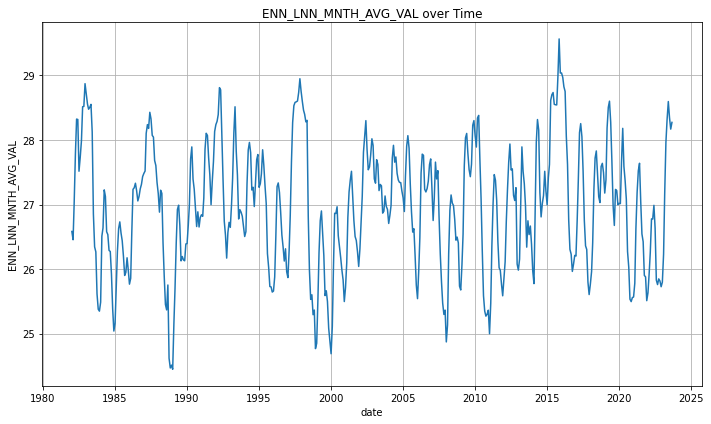

In [13]:
# drawing
plt.figure(figsize=(10, 6))
plt.plot(df.WTCH_YM, df.ENN_LNN_MNTH_AVG_VAL)
plt.xlabel('date')
plt.ylabel('ENN_LNN_MNTH_AVG_VAL')
plt.title('ENN_LNN_MNTH_AVG_VAL over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
train_df = df[df['WTCH_YM'] < '2020-01-01']
test_df = df[df['WTCH_YM'] >= '2020-01-01']

In [15]:
def make_series(data, window=1, dropnan=True):
    cols, names = [], []
    
    for i in range(window, 0, -1):
        cols.append(data.shift(i)) # shift: 행의 위치를 이동 [양수: 아래, 음수: 위]
        names += [f'{col_name}(t-{i})' for col_name in data.columns]
    
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]
    
    cols.append(data.shift(-1))
    names += [f'{col}(t+1)' for col in data.columns]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
window = 11
series = make_series(train_df.drop('WTCH_YM', axis=1), window=window)
print(series.head())

labels_col = 'ENN_LNN_MNTH_AVG_VAL(t+1)' # label is t+1 
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print(X_train.head())

    ENN_LNN_MNTH_AVG_VAL(t-11)  ENN_LNN_MNTH_AVG_VAL(t-10)  ENN_LNN_MNTH_AVG_VAL(t-9)  ENN_LNN_MNTH_AVG_VAL(t-8)  ENN_LNN_MNTH_AVG_VAL(t-7)  ENN_LNN_MNTH_AVG_VAL(t-6)  ENN_LNN_MNTH_AVG_VAL(t-5)  ENN_LNN_MNTH_AVG_VAL(t-4)  ENN_LNN_MNTH_AVG_VAL(t-3)  ENN_LNN_MNTH_AVG_VAL(t-2)  ENN_LNN_MNTH_AVG_VAL(t-1)  ENN_LNN_MNTH_AVG_VAL(t)  ENN_LNN_MNTH_AVG_VAL(t+1)
11                   26.583536                   26.455164                  27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                28.873512                  28.718626
12                   26.455164                   27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                  

In [17]:
# given y_true, y_pred list, calculate r2, corr, mape, rmse than return result with df
def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        'R2': r2,
        "Corr": corr,
        "RMSE": rmse,
        "MAPE": mape
    }, index=[0]) # 1행 데이터이므로 index를 0 하나만 부여
    return df

In [18]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
def MinMax(y_true, y_pred, m='min'):
    if m == 'min':
        return min(min(y_true), min(y_pred)) - 2
    else:
        return max(max(y_true), max(y_pred)) + 2
    
# x = date, y = MeanTemp
def myGraph(temp, title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [2.5, 1]})
    axs[0].plot(temp['WTCH_YM'], temp['y_true'], label = 'Original')
    axs[0].plot(temp['WTCH_YM'], temp['y_pred'], label = 'Predicted')
    axs[0].legend(loc='upper right')
    axs[0].title.set_text(title)
    axs[0].set_xlabel('WTCH_YM')
    axs[0].set_ylabel('ENN_LNN_MNTH_AVG_VAL')
    
    axs[1].plot(temp.y_true, temp.y_pred, '.')
    plt.xlim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    plt.ylim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    abline(1,0)
    plt.title(title)
    plt.xlabel('Original')
    plt.ylabel('Predicted')
    

In [32]:
epochs = 1000
batch = 256
lr = 0.0003


# CNN

In [29]:
#(n, 12) -> (n, 12, 1)
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=adam)

model_cnn.summary()

# variables = model_cnn.trainable_variables
# adam = optimizers.Adam(lr)
# # adam.build(variables)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_9 (Conv1D)           (None, 11, 64)            192       
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 5, 64)            0         
 1D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 320)               0         
                                                                 
 dense_18 (Dense)            (None, 50)                16050     
                                                                 
 dense_19 (Dense)            (None, 1)                 51        
                                                                 
Total params: 16,293
Trainable params: 16,293
Non-trainable params: 0
__________________________________________________

In [33]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)

Y_train_ = pd.DataFrame({'y_true': Y_train, 'y_pred': cnn_train_pred.reshape(cnn_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
#merge by using index
Y_train_ = pd.merge(Y_train_, train_df, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true': Y_valid, 'y_pred': cnn_valid_pred.reshape(cnn_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_df, left_index=True, right_index=True, how='left')

Epoch 1/1000
9/9 - 0s - loss: 0.5902 - val_loss: 0.7260 - 91ms/epoch - 10ms/step
Epoch 2/1000
9/9 - 0s - loss: 0.5576 - val_loss: 0.8113 - 67ms/epoch - 7ms/step
Epoch 3/1000
9/9 - 0s - loss: 0.6811 - val_loss: 0.6650 - 77ms/epoch - 9ms/step
Epoch 4/1000
9/9 - 0s - loss: 0.5715 - val_loss: 0.5638 - 85ms/epoch - 9ms/step
Epoch 5/1000
9/9 - 0s - loss: 0.5432 - val_loss: 0.5616 - 92ms/epoch - 10ms/step
Epoch 6/1000
9/9 - 0s - loss: 0.5203 - val_loss: 0.6468 - 54ms/epoch - 6ms/step
Epoch 7/1000
9/9 - 0s - loss: 0.5984 - val_loss: 0.5698 - 49ms/epoch - 5ms/step
Epoch 8/1000
9/9 - 0s - loss: 0.5163 - val_loss: 0.5545 - 49ms/epoch - 5ms/step
Epoch 9/1000
9/9 - 0s - loss: 0.5072 - val_loss: 0.5643 - 47ms/epoch - 5ms/step
Epoch 10/1000
9/9 - 0s - loss: 0.5288 - val_loss: 0.5614 - 50ms/epoch - 6ms/step
Epoch 11/1000
9/9 - 0s - loss: 0.5056 - val_loss: 0.5558 - 45ms/epoch - 5ms/step
Epoch 12/1000
9/9 - 0s - loss: 0.5086 - val_loss: 0.5618 - 49ms/epoch - 5ms/step
Epoch 13/1000
9/9 - 0s - loss: 0.53

Epoch 103/1000
9/9 - 0s - loss: 0.4996 - val_loss: 0.5425 - 58ms/epoch - 6ms/step
Epoch 104/1000
9/9 - 0s - loss: 0.4789 - val_loss: 0.5503 - 61ms/epoch - 7ms/step
Epoch 105/1000
9/9 - 0s - loss: 0.5074 - val_loss: 0.5675 - 56ms/epoch - 6ms/step
Epoch 106/1000
9/9 - 0s - loss: 0.5043 - val_loss: 0.5411 - 48ms/epoch - 5ms/step
Epoch 107/1000
9/9 - 0s - loss: 0.4753 - val_loss: 0.6377 - 48ms/epoch - 5ms/step
Epoch 108/1000
9/9 - 0s - loss: 0.5159 - val_loss: 0.6542 - 46ms/epoch - 5ms/step
Epoch 109/1000
9/9 - 0s - loss: 0.5451 - val_loss: 0.6315 - 49ms/epoch - 5ms/step
Epoch 110/1000
9/9 - 0s - loss: 0.5043 - val_loss: 0.5408 - 48ms/epoch - 5ms/step
Epoch 111/1000
9/9 - 0s - loss: 0.5471 - val_loss: 0.6056 - 46ms/epoch - 5ms/step
Epoch 112/1000
9/9 - 0s - loss: 0.5531 - val_loss: 0.5978 - 54ms/epoch - 6ms/step
Epoch 113/1000
9/9 - 0s - loss: 0.5138 - val_loss: 0.5529 - 56ms/epoch - 6ms/step
Epoch 114/1000
9/9 - 0s - loss: 0.4884 - val_loss: 0.5363 - 55ms/epoch - 6ms/step
Epoch 115/1000
9

Epoch 203/1000
9/9 - 0s - loss: 0.4643 - val_loss: 0.5241 - 48ms/epoch - 5ms/step
Epoch 204/1000
9/9 - 0s - loss: 0.4689 - val_loss: 0.5275 - 47ms/epoch - 5ms/step
Epoch 205/1000
9/9 - 0s - loss: 0.4609 - val_loss: 0.5911 - 49ms/epoch - 5ms/step
Epoch 206/1000
9/9 - 0s - loss: 0.4748 - val_loss: 0.5364 - 46ms/epoch - 5ms/step
Epoch 207/1000
9/9 - 0s - loss: 0.4663 - val_loss: 0.5249 - 46ms/epoch - 5ms/step
Epoch 208/1000
9/9 - 0s - loss: 0.4976 - val_loss: 0.5244 - 48ms/epoch - 5ms/step
Epoch 209/1000
9/9 - 0s - loss: 0.4824 - val_loss: 0.5272 - 49ms/epoch - 5ms/step
Epoch 210/1000
9/9 - 0s - loss: 0.4821 - val_loss: 0.5438 - 49ms/epoch - 5ms/step
Epoch 211/1000
9/9 - 0s - loss: 0.5025 - val_loss: 0.5238 - 48ms/epoch - 5ms/step
Epoch 212/1000
9/9 - 0s - loss: 0.4889 - val_loss: 0.5228 - 48ms/epoch - 5ms/step
Epoch 213/1000
9/9 - 0s - loss: 0.4703 - val_loss: 0.5228 - 50ms/epoch - 6ms/step
Epoch 214/1000
9/9 - 0s - loss: 0.4886 - val_loss: 0.5250 - 49ms/epoch - 5ms/step
Epoch 215/1000
9

Epoch 303/1000
9/9 - 0s - loss: 0.4888 - val_loss: 0.5218 - 49ms/epoch - 5ms/step
Epoch 304/1000
9/9 - 0s - loss: 0.4670 - val_loss: 0.5109 - 52ms/epoch - 6ms/step
Epoch 305/1000
9/9 - 0s - loss: 0.4642 - val_loss: 0.5259 - 59ms/epoch - 7ms/step
Epoch 306/1000
9/9 - 0s - loss: 0.5740 - val_loss: 0.6449 - 63ms/epoch - 7ms/step
Epoch 307/1000
9/9 - 0s - loss: 0.4648 - val_loss: 0.5800 - 57ms/epoch - 6ms/step
Epoch 308/1000
9/9 - 0s - loss: 0.4825 - val_loss: 0.5141 - 48ms/epoch - 5ms/step
Epoch 309/1000
9/9 - 0s - loss: 0.4766 - val_loss: 0.5156 - 46ms/epoch - 5ms/step
Epoch 310/1000
9/9 - 0s - loss: 0.4488 - val_loss: 0.5096 - 49ms/epoch - 5ms/step
Epoch 311/1000
9/9 - 0s - loss: 0.4520 - val_loss: 0.5227 - 57ms/epoch - 6ms/step
Epoch 312/1000
9/9 - 0s - loss: 0.4640 - val_loss: 0.5436 - 57ms/epoch - 6ms/step
Epoch 313/1000
9/9 - 0s - loss: 0.4710 - val_loss: 0.6304 - 61ms/epoch - 7ms/step
Epoch 314/1000
9/9 - 0s - loss: 0.5014 - val_loss: 0.5892 - 53ms/epoch - 6ms/step
Epoch 315/1000
9

Epoch 403/1000
9/9 - 0s - loss: 0.5145 - val_loss: 0.5181 - 49ms/epoch - 5ms/step
Epoch 404/1000
9/9 - 0s - loss: 0.4466 - val_loss: 0.5150 - 47ms/epoch - 5ms/step
Epoch 405/1000
9/9 - 0s - loss: 0.4321 - val_loss: 0.5027 - 48ms/epoch - 5ms/step
Epoch 406/1000
9/9 - 0s - loss: 0.4388 - val_loss: 0.4995 - 49ms/epoch - 5ms/step
Epoch 407/1000
9/9 - 0s - loss: 0.4415 - val_loss: 0.5290 - 49ms/epoch - 5ms/step
Epoch 408/1000
9/9 - 0s - loss: 0.4460 - val_loss: 0.4978 - 48ms/epoch - 5ms/step
Epoch 409/1000
9/9 - 0s - loss: 0.4425 - val_loss: 0.4974 - 47ms/epoch - 5ms/step
Epoch 410/1000
9/9 - 0s - loss: 0.4359 - val_loss: 0.6335 - 49ms/epoch - 5ms/step
Epoch 411/1000
9/9 - 0s - loss: 0.4880 - val_loss: 0.6630 - 49ms/epoch - 5ms/step
Epoch 412/1000
9/9 - 0s - loss: 0.5448 - val_loss: 0.6046 - 47ms/epoch - 5ms/step
Epoch 413/1000
9/9 - 0s - loss: 0.6427 - val_loss: 0.5029 - 50ms/epoch - 6ms/step
Epoch 414/1000
9/9 - 0s - loss: 0.4883 - val_loss: 0.5381 - 49ms/epoch - 5ms/step
Epoch 415/1000
9

Epoch 503/1000
9/9 - 0s - loss: 0.4908 - val_loss: 0.5060 - 50ms/epoch - 6ms/step
Epoch 504/1000
9/9 - 0s - loss: 0.4617 - val_loss: 0.5453 - 47ms/epoch - 5ms/step
Epoch 505/1000
9/9 - 0s - loss: 0.4715 - val_loss: 0.4863 - 47ms/epoch - 5ms/step
Epoch 506/1000
9/9 - 0s - loss: 0.4334 - val_loss: 0.4882 - 47ms/epoch - 5ms/step
Epoch 507/1000
9/9 - 0s - loss: 0.4268 - val_loss: 0.4867 - 45ms/epoch - 5ms/step
Epoch 508/1000
9/9 - 0s - loss: 0.4246 - val_loss: 0.5376 - 47ms/epoch - 5ms/step
Epoch 509/1000
9/9 - 0s - loss: 0.4452 - val_loss: 0.4889 - 48ms/epoch - 5ms/step
Epoch 510/1000
9/9 - 0s - loss: 0.5051 - val_loss: 0.4888 - 48ms/epoch - 5ms/step
Epoch 511/1000
9/9 - 0s - loss: 0.4892 - val_loss: 0.4984 - 52ms/epoch - 6ms/step
Epoch 512/1000
9/9 - 0s - loss: 0.4439 - val_loss: 0.5183 - 46ms/epoch - 5ms/step
Epoch 513/1000
9/9 - 0s - loss: 0.4614 - val_loss: 0.4869 - 50ms/epoch - 6ms/step
Epoch 514/1000
9/9 - 0s - loss: 0.4346 - val_loss: 0.4848 - 49ms/epoch - 5ms/step
Epoch 515/1000
9

Epoch 603/1000
9/9 - 0s - loss: 0.4535 - val_loss: 0.4783 - 50ms/epoch - 6ms/step
Epoch 604/1000
9/9 - 0s - loss: 0.4217 - val_loss: 0.4814 - 48ms/epoch - 5ms/step
Epoch 605/1000
9/9 - 0s - loss: 0.4322 - val_loss: 0.4982 - 45ms/epoch - 5ms/step
Epoch 606/1000
9/9 - 0s - loss: 0.4193 - val_loss: 0.4912 - 48ms/epoch - 5ms/step
Epoch 607/1000
9/9 - 0s - loss: 0.4442 - val_loss: 0.4873 - 48ms/epoch - 5ms/step
Epoch 608/1000
9/9 - 0s - loss: 0.4097 - val_loss: 0.4738 - 49ms/epoch - 5ms/step
Epoch 609/1000
9/9 - 0s - loss: 0.4259 - val_loss: 0.5060 - 52ms/epoch - 6ms/step
Epoch 610/1000
9/9 - 0s - loss: 0.4395 - val_loss: 0.6338 - 48ms/epoch - 5ms/step
Epoch 611/1000
9/9 - 0s - loss: 0.4882 - val_loss: 0.5458 - 46ms/epoch - 5ms/step
Epoch 612/1000
9/9 - 0s - loss: 0.4637 - val_loss: 0.5671 - 49ms/epoch - 5ms/step
Epoch 613/1000
9/9 - 0s - loss: 0.5226 - val_loss: 0.4735 - 50ms/epoch - 6ms/step
Epoch 614/1000
9/9 - 0s - loss: 0.4287 - val_loss: 0.4735 - 49ms/epoch - 5ms/step
Epoch 615/1000
9

Epoch 703/1000
9/9 - 0s - loss: 0.4880 - val_loss: 0.4679 - 48ms/epoch - 5ms/step
Epoch 704/1000
9/9 - 0s - loss: 0.4502 - val_loss: 0.4990 - 50ms/epoch - 6ms/step
Epoch 705/1000
9/9 - 0s - loss: 0.3994 - val_loss: 0.4681 - 49ms/epoch - 5ms/step
Epoch 706/1000
9/9 - 0s - loss: 0.4019 - val_loss: 0.4808 - 49ms/epoch - 5ms/step
Epoch 707/1000
9/9 - 0s - loss: 0.4132 - val_loss: 0.4935 - 48ms/epoch - 5ms/step
Epoch 708/1000
9/9 - 0s - loss: 0.4023 - val_loss: 0.4751 - 51ms/epoch - 6ms/step
Epoch 709/1000
9/9 - 0s - loss: 0.3986 - val_loss: 0.5041 - 49ms/epoch - 5ms/step
Epoch 710/1000
9/9 - 0s - loss: 0.4252 - val_loss: 0.4647 - 49ms/epoch - 5ms/step
Epoch 711/1000
9/9 - 0s - loss: 0.4148 - val_loss: 0.4730 - 49ms/epoch - 5ms/step
Epoch 712/1000
9/9 - 0s - loss: 0.4098 - val_loss: 0.4737 - 48ms/epoch - 5ms/step
Epoch 713/1000
9/9 - 0s - loss: 0.4154 - val_loss: 0.5792 - 49ms/epoch - 5ms/step
Epoch 714/1000
9/9 - 0s - loss: 0.4299 - val_loss: 0.4645 - 48ms/epoch - 5ms/step
Epoch 715/1000
9

Epoch 803/1000
9/9 - 0s - loss: 0.4256 - val_loss: 0.4605 - 51ms/epoch - 6ms/step
Epoch 804/1000
9/9 - 0s - loss: 0.3857 - val_loss: 0.5101 - 46ms/epoch - 5ms/step
Epoch 805/1000
9/9 - 0s - loss: 0.4496 - val_loss: 0.4570 - 49ms/epoch - 5ms/step
Epoch 806/1000
9/9 - 0s - loss: 0.4042 - val_loss: 0.5340 - 50ms/epoch - 6ms/step
Epoch 807/1000
9/9 - 0s - loss: 0.4140 - val_loss: 0.4576 - 51ms/epoch - 6ms/step
Epoch 808/1000
9/9 - 0s - loss: 0.4164 - val_loss: 0.4805 - 47ms/epoch - 5ms/step
Epoch 809/1000
9/9 - 0s - loss: 0.3924 - val_loss: 0.4869 - 48ms/epoch - 5ms/step
Epoch 810/1000
9/9 - 0s - loss: 0.3942 - val_loss: 0.4603 - 52ms/epoch - 6ms/step
Epoch 811/1000
9/9 - 0s - loss: 0.3905 - val_loss: 0.4792 - 49ms/epoch - 5ms/step
Epoch 812/1000
9/9 - 0s - loss: 0.3937 - val_loss: 0.4515 - 47ms/epoch - 5ms/step
Epoch 813/1000
9/9 - 0s - loss: 0.3914 - val_loss: 0.4694 - 46ms/epoch - 5ms/step
Epoch 814/1000
9/9 - 0s - loss: 0.4149 - val_loss: 0.5070 - 48ms/epoch - 5ms/step
Epoch 815/1000
9

Epoch 903/1000
9/9 - 0s - loss: 0.3951 - val_loss: 0.5951 - 49ms/epoch - 5ms/step
Epoch 904/1000
9/9 - 0s - loss: 0.4675 - val_loss: 0.4444 - 48ms/epoch - 5ms/step
Epoch 905/1000
9/9 - 0s - loss: 0.4316 - val_loss: 0.4595 - 48ms/epoch - 5ms/step
Epoch 906/1000
9/9 - 0s - loss: 0.4226 - val_loss: 0.5412 - 48ms/epoch - 5ms/step
Epoch 907/1000
9/9 - 0s - loss: 0.5148 - val_loss: 0.4809 - 50ms/epoch - 6ms/step
Epoch 908/1000
9/9 - 0s - loss: 0.4101 - val_loss: 0.4408 - 49ms/epoch - 5ms/step
Epoch 909/1000
9/9 - 0s - loss: 0.3754 - val_loss: 0.4432 - 49ms/epoch - 5ms/step
Epoch 910/1000
9/9 - 0s - loss: 0.3769 - val_loss: 0.4415 - 48ms/epoch - 5ms/step
Epoch 911/1000
9/9 - 0s - loss: 0.3691 - val_loss: 0.5136 - 48ms/epoch - 5ms/step
Epoch 912/1000
9/9 - 0s - loss: 0.3885 - val_loss: 0.4409 - 49ms/epoch - 5ms/step
Epoch 913/1000
9/9 - 0s - loss: 0.3945 - val_loss: 0.4419 - 49ms/epoch - 5ms/step
Epoch 914/1000
9/9 - 0s - loss: 0.4548 - val_loss: 0.4591 - 48ms/epoch - 5ms/step
Epoch 915/1000
9

In [34]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,42.766,0.8,0.75,2.237


In [35]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,MAPE
0,35.022,0.735,0.759,2.248


Obs of Valid Set:  178


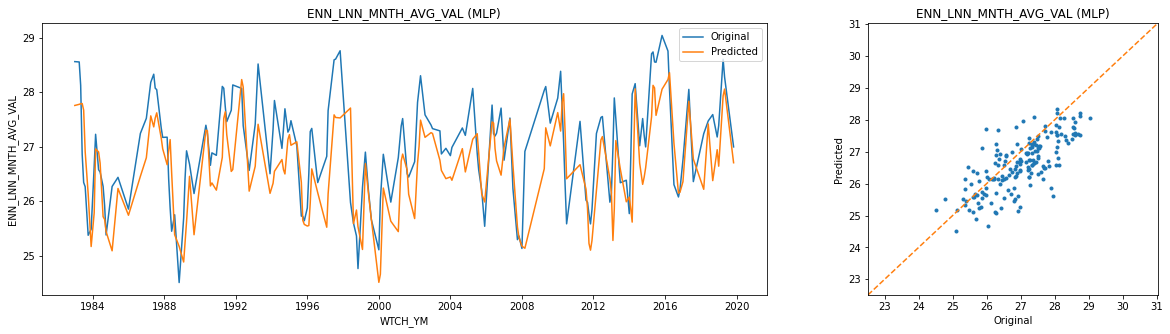

In [36]:
print('Obs of Valid Set: ', Y_valid_.shape[0])
myGraph(Y_valid_, 'ENN_LNN_MNTH_AVG_VAL (MLP)')